# Section I: Preparation

# 1. Imports & Constants

In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from IPython.display import display, Markdown

In [2]:
# Constants
CLUSTERING_METRICS = ['ari', 'chs']

In [3]:
# constants
CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL = 'ari'
CLUSTERING_METRIC_TO_CONSIDER_INTERNAL = 'chs'

In [4]:
DATASETS_TO_SKIP = []  # put any datasets to skip here

In [5]:
MODEL_TO_DISPLAY_NAME_MAP = {
    'lstm-auto-encoder - encoder': 'LSTM-AE',
    'ts2vec - ts2vec': 'TS2Vec',
    'mcl - mcl': 'MCL',
    'timenet - timenet': 'TimeNet',
    'tsrc-mcl-lstmae - student-model-encoder': 'LSTM-AE w/ TSRC (MCL)',
    'tsrc-ts2vec-lstmae - student-model-encoder': 'LSTM-AE w/ TSRC (TS2Vec)',
    'tsrc-ts2vec-timenet - student-model-encoder': 'TimeNet w/ TSRC (TS2Vec)',
    'raw': 'Raw Data',
}

In [6]:
EXPERIMENTS_MAIN_OUTPUTS_DIR = Path('../experiments_outputs/')
CLUSTERING_MAIN_RESULTS_DIR = EXPERIMENTS_MAIN_OUTPUTS_DIR / 'clustering'

In [7]:
# Make a directory for storing the plots
PLOTS_OUTPUT_DIR = Path('./analysis_output')
PLOTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2. Functions

## 2.1. Plotting Functions

In [8]:
# This function is taken from Orange3 v.3.29.3 source code under GNU [GPL-3.0] license

def compute_CD(avranks, num_datasets, alpha="0.05", test="nemenyi"):
    """
    Computes the Critical Difference for Nemenyi test.
    """
    k = len(avranks)
    print(f"Number of datasets: {num_datasets}")
    print(f"Number of algorithms: {k}")
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * num_datasets)) ** 0.5
    return cd

In [9]:
# This function is taken from Orange3 v.3.29.3 source code under GNU [GPL-3.0] license

def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]

            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

## 2.2. Statistical Tests Functions

In [10]:
def perform_cd_analysis_multiple(means, algorithm_names, alpha="0.05"):
    """
    Perform Critical Difference Analysis with multiple runs.
    means is a 3D array: datasets x runs x algorithms
    """
    # Flatten runs and datasets into one dimension while keeping algorithms separate
    reshaped_means = means.reshape(-1, means.shape[2]).T
    ranks = np.array([stats.rankdata(-m) for m in reshaped_means.T])
    avg_ranks = np.mean(ranks, axis=0)
    stat, p_value = stats.friedmanchisquare(*reshaped_means)

    print(f"Statistics={stat}, p={p_value}")

    if p_value < 0.05:
        print("Significant differences found. Proceeding to CD analysis.")
        cd = compute_CD(avg_ranks, reshaped_means.shape[1], alpha)
        print(f"Critical difference: {cd}")
        # Print ranking of each algorithm
        sorted_indexes = np.argsort(avg_ranks)
        print("\nAlgorithm Name                 Rank")
        print("-------------------------------------")
        for i in sorted_indexes:
            print(f"{algorithm_names[i]:30s} {avg_ranks[i]:.2f}")
        graph_ranks(avranks=avg_ranks, names=algorithm_names, cd=cd, reverse=True, filename=None)
    else:
        print("No significant differences found.")


In [11]:
def do_cd_analysis_multiple(results_table, algorithms_names, algorithms_display_name):
    """
    Perform Critical Difference Analysis with multiple runs data.
    
    Arguments:
    results_table: DataFrame where each cell contains a list of performance data.
    algorithms_names: List of column names in results_table that correspond to different algorithms.
    algorithms_display_name: List of names for displaying the results.
    """
    # Gather all dataset names (index of the DataFrame)
    datasets = results_table.index.tolist()

    # Determine the number of runs (assuming uniform across all cells)
    number_of_runs = len(results_table.iloc[0, 0])

    # Preparing the 3D array: datasets x runs x algorithms
    data = np.empty((len(datasets), number_of_runs, len(algorithms_names)))

    for i, algorithm in enumerate(algorithms_names):
        for j, dataset in enumerate(datasets):
            data[j, :, i] = results_table.at[dataset, algorithm]

    # Pass the prepared data to the analysis function
    perform_cd_analysis_multiple(data, algorithms_display_name)


## 2.3. Utils Functions

In [12]:
def save_df_as_latex(df, filename, output_dir_path: Path = PLOTS_OUTPUT_DIR):
    """
    Save a DataFrame as a LaTeX table in a file.
    """
    df_copy = df.fillna('')  # Fill NaN values with empty strings

    full_file_path = output_dir_path / f'{filename}.tex'
    with open(full_file_path, 'w') as f:
        f.write(df_copy.style.to_latex(hrules=True, multicol_align='c', multirow_align='c'))

## 2.4. Data Processing Functions

In [13]:
def process_df_raw_data_results(datasets_to_skip, metric_to_keep):

    df_results_all = pd.DataFrame()
    base_results_dir = CLUSTERING_MAIN_RESULTS_DIR / 'raw'

    # Collect results from each seed
    for seed_number in [1, 3, 5, 7, 9]:
        results_file = base_results_dir / f'raw_clu_clustering_results_seed_{seed_number}.csv'
        if results_file.exists():
            df_seed = pd.read_csv(results_file)
            # Filter and keep only needed columns
            df_seed = df_seed[['dataset_name', metric_to_keep]].copy()
            # Add to overall results
            df_results_all = pd.concat([df_results_all, df_seed], ignore_index=True)

    # Process the combined results
    if df_results_all.empty:
        raise FileNotFoundError("No raw data clustering result files found")

    # Group by dataset_name to get lists of metric values
    df_grouped = df_results_all.groupby('dataset_name')[metric_to_keep].apply(list).reset_index()

    # Filter out datasets to skip
    df_filtered = df_grouped[~df_grouped['dataset_name'].isin(datasets_to_skip)].copy()

    # Set index and rename column
    df_filtered.set_index('dataset_name', inplace=True, drop=True)
    df_filtered.rename(columns={metric_to_keep: 'raw'}, inplace=True)

    # Create a copy for mean ± std format
    df_filtered_mean_std = df_filtered.copy()
    df_filtered_mean_std['raw'] = df_filtered_mean_std['raw'].apply(lambda x: f"{np.mean(x):.2f} ± {np.std(x):.2f}")

    return df_filtered, df_filtered_mean_std

In [14]:
def process_df_representations_results(df_results, datasets_to_skip):
    df_filtered = df_results[~df_results['dataset_name'].isin(datasets_to_skip)].copy()
    df_filtered['model_encoder_pair'] = df_filtered['model_name'] + " - " + df_filtered['encoder_name']
    return df_filtered

In [15]:
def compute_metrics_across_runs_representations(list_df_data,
                                                encoders_list,
                                                metrics,
                                                aggregate=True,
                                                values_format="mean"):
    encoder_metric_tables = {encoder: {} for encoder in encoders_list}
    metric_encoder_tables = {metric: {} for metric in metrics}

    # Table 1: One table per encoder
    for encoder in encoders_list:
        dataset_metric_values = {}

        for metric in metrics:
            for df_data in list_df_data:
                for dataset in df_data['dataset_name'].unique():
                    if dataset not in dataset_metric_values:
                        dataset_metric_values[dataset] = {m: [] for m in metrics}

            for df_data in list_df_data:
                df_filtered_data = df_data[df_data['model_encoder_pair'] == encoder]
                for dataset in df_filtered_data['dataset_name'].unique():
                    values = df_filtered_data[df_filtered_data['dataset_name'] == dataset][metric].tolist()
                    dataset_metric_values[dataset][metric].extend(values)

        if aggregate:
            for dataset, metrics_values in dataset_metric_values.items():
                for m, values in metrics_values.items():
                    mean = np.mean(values)
                    std = np.std(values)
                    dataset_metric_values[dataset][
                        m] = f"{mean:.2f} ± {std:.2f}" if values_format == 'mean_std' else mean

        result_table = pd.DataFrame.from_dict(dataset_metric_values, orient='index')
        encoder_metric_tables[encoder] = result_table

    # Table 2: One table per metric
    for metric in metrics:
        encoder_values = {}

        for encoder in encoders_list:
            for df_data in list_df_data:
                for dataset in df_data['dataset_name'].unique():
                    if dataset not in encoder_values:
                        encoder_values[dataset] = {e: [] for e in encoders_list}

            for df_data in list_df_data:
                df_filtered_data = df_data[df_data['model_encoder_pair'] == encoder]
                for dataset in df_filtered_data['dataset_name'].unique():
                    values = df_filtered_data[df_filtered_data['dataset_name'] == dataset][metric].tolist()
                    encoder_values[dataset][encoder].extend(values)

        if aggregate:
            for dataset, encoders_values in encoder_values.items():
                for e, values in encoders_values.items():
                    mean = np.mean(values)
                    std = np.std(values)
                    encoder_values[dataset][e] = f"{mean:.2f} ± {std:.2f}" if values_format == 'mean_std' else mean

        result_table = pd.DataFrame.from_dict(encoder_values, orient='index')
        metric_encoder_tables[metric] = result_table

    return encoder_metric_tables, metric_encoder_tables


In [16]:
def process_and_prepare_representations_data(data_folder_path: Path,
                                             datasets_to_skip: list,
                                             encoders_list: list,
                                             metrics: list,
                                             aggregate: bool = True,
                                             values_format: str = 'mean'):
    csv_files = [file for file in data_folder_path.iterdir() if file.suffix == '.csv']

    results_files_dataframes = [pd.read_csv(file) for file in csv_files]

    results_files_dataframes = [process_df_representations_results(df, datasets_to_skip) for df in
                                results_files_dataframes]

    encoder_metric_tables, metric_encoder_tables = compute_metrics_across_runs_representations(
        list_df_data=results_files_dataframes,
        encoders_list=encoders_list,
        metrics=metrics,
        aggregate=aggregate,
        values_format=values_format)

    return encoder_metric_tables, metric_encoder_tables

In [17]:
def analyze_representation_results(representations_results_folder: Path,
                                   metrics: list,
                                   encoders_list: list, ):
    encoder_metric_tables_display, metric_encoder_tables_display = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        values_format='mean_std')

    for metric in metrics:
        display(Markdown(f'### {metric.upper()} ###'))
        display(metric_encoder_tables_display[metric].sort_index())

    encoder_metric_tables, metric_encoder_tables = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        values_format='mean')

    return encoder_metric_tables, metric_encoder_tables, encoder_metric_tables_display, metric_encoder_tables_display

In [18]:
def analyze_representation_results_2(representations_results_folder: Path,
                                     metrics: list,
                                     encoders_list: list, ):
    encoder_metric_tables_mul, metric_encoder_tables_mul = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        aggregate=False,
        values_format='mean_std')

    return encoder_metric_tables_mul, metric_encoder_tables_mul

### 2.5. Summarising

In [19]:
def summarize_baselines_results(baselines_tables: dict,
                                clustering_metric_to_consider: str = CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL):
    df_summarized_baselines_results = pd.DataFrame()
    for baseline_name, baseline_table in baselines_tables.items():
        metric_table = baseline_table[clustering_metric_to_consider]
        df_summarized_baselines_results = pd.concat(
            [df_summarized_baselines_results, metric_table],
            axis=1)

    return df_summarized_baselines_results

# Section II: Analysis

# 3. Baselines

In [20]:
BASELINES_MAIN_DIR = CLUSTERING_MAIN_RESULTS_DIR / 'baselines'

## 3.1. LSTM Autoencoder (LSTM-AE)

In [21]:
lstm_ae_encoders_list = ['lstm-auto-encoder - encoder']
lstm_ae_main_dir = BASELINES_MAIN_DIR / 'ae'
lstm_ae_results_dir = lstm_ae_main_dir / 'compression_2'

In [22]:
lstm_ae_comp_2_encoder_metric_tables, lstm_ae_comp_2_metric_encoder_tables, lstm_ae_comp_2_encoder_metric_tables_display, lstm_ae_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=lstm_ae_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=lstm_ae_encoders_list)

### ARI ###

,lstm-auto-encoder - encoder
ACSF1,0.22 ± 0.01
Adiac,0.12 ± 0.03
ArrowHead,0.05 ± 0.01
BME,0.22 ± 0.07
Beef,0.04 ± 0.00
...,...
Wine,-0.01 ± 0.00
WordSynonyms,0.06 ± 0.01
Worms,0.04 ± 0.00
WormsTwoClass,-0.00 ± 0.00


### CHS ###

,lstm-auto-encoder - encoder
ACSF1,124.22 ± 27.73
Adiac,549.68 ± 322.67
ArrowHead,119.86 ± 32.01
BME,182.64 ± 78.64
Beef,1212.85 ± 418.01
...,...
Wine,55.94 ± 13.78
WordSynonyms,269.52 ± 59.45
Worms,394.48 ± 6.15
WormsTwoClass,268.58 ± 1.22


In [23]:
lstm_ae_comp_2_encoder_metric_tables_mul, lstm_ae_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=lstm_ae_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=lstm_ae_encoders_list)

## 3.2. TS2Vec

In [24]:
ts2vec_encoders_list = ['ts2vec - ts2vec']
ts2vec_main_dir = BASELINES_MAIN_DIR / 'ts2vec'
ts2vec_results_dir = ts2vec_main_dir / 'compression_2'

In [25]:
ts2vec_comp_2_encoder_metric_tables, ts2vec_comp_2_metric_encoder_tables, ts2vec_comp_2_encoder_metric_tables_display, ts2vec_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=ts2vec_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=ts2vec_encoders_list)

### ARI ###

,ts2vec - ts2vec
ACSF1,0.18 ± 0.03
Adiac,0.25 ± 0.01
ArrowHead,-0.01 ± 0.00
BME,-0.00 ± 0.00
Beef,0.08 ± 0.03
...,...
Wine,-0.01 ± 0.01
WordSynonyms,0.20 ± 0.02
Worms,0.05 ± 0.01
WormsTwoClass,0.05 ± 0.02


### CHS ###

,ts2vec - ts2vec
ACSF1,164.76 ± 33.72
Adiac,106.86 ± 19.94
ArrowHead,63.58 ± 9.14
BME,462.14 ± 80.76
Beef,44.79 ± 6.51
...,...
Wine,41.02 ± 2.10
WordSynonyms,25.22 ± 2.80
Worms,22.74 ± 3.37
WormsTwoClass,32.79 ± 4.33


In [26]:
ts2vec_comp_2_encoder_metric_tables_mul, ts2vec_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=ts2vec_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=ts2vec_encoders_list)

## 3.3. MCL

In [27]:
mcl_encoders_list = ['mcl - mcl']
mcl_main_dir = BASELINES_MAIN_DIR / 'mcl'
mcl_results_dir = mcl_main_dir / 'compression_2'

In [28]:
mcl_comp_2_encoder_metric_tables, mcl_comp_2_metric_encoder_tables, mcl_comp_2_encoder_metrics_tables_display, mcl_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=mcl_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=mcl_encoders_list)

### ARI ###

,mcl - mcl
ACSF1,0.26 ± 0.01
Adiac,0.30 ± 0.02
ArrowHead,0.09 ± 0.04
BME,0.25 ± 0.07
Beef,0.18 ± 0.07
...,...
Wine,0.04 ± 0.05
WordSynonyms,0.14 ± 0.01
Worms,0.00 ± 0.01
WormsTwoClass,-0.00 ± 0.00


### CHS ###

,mcl - mcl
ACSF1,67.70 ± 13.01
Adiac,93.71 ± 9.83
ArrowHead,33.99 ± 6.30
BME,24.75 ± 3.34
Beef,25.39 ± 7.57
...,...
Wine,18.71 ± 3.79
WordSynonyms,40.03 ± 3.83
Worms,18.98 ± 1.48
WormsTwoClass,23.65 ± 1.19


In [29]:
mcl_comp_2_encoder_metric_tables_mul, mcl_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=mcl_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=mcl_encoders_list)

## 3.4. TimeNet

In [30]:
timenet_encoders_list = ['timenet - timenet']
timenet_main_dir = BASELINES_MAIN_DIR / 'timenet'
timenet_results_dir = timenet_main_dir / 'compression_2'

In [31]:
timenet_comp_2_encoder_metric_tables, timenet_comp_2_metric_encoder_tables, timenet_comp_2_encoder_metrics_tables_display, timenet_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=timenet_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=timenet_encoders_list)

### ARI ###

,timenet - timenet
ACSF1,0.22 ± 0.02
Adiac,0.15 ± 0.01
ArrowHead,0.05 ± 0.02
BME,0.37 ± 0.18
Beef,0.08 ± 0.04
...,...
Wine,0.01 ± 0.02
WordSynonyms,0.16 ± 0.01
Worms,0.06 ± 0.01
WormsTwoClass,0.00 ± 0.01


### CHS ###

,timenet - timenet
ACSF1,106.62 ± 23.38
Adiac,410.73 ± 136.96
ArrowHead,70.94 ± 24.64
BME,64.21 ± 8.69
Beef,180.20 ± 140.03
...,...
Wine,33.06 ± 5.19
WordSynonyms,95.94 ± 20.68
Worms,103.10 ± 68.16
WormsTwoClass,50.21 ± 6.22


In [32]:
timenet_comp_2_encoder_metric_tables_mul, timenet_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=timenet_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=timenet_encoders_list)

## 3.5. Baselines Summary

In [33]:
baselines_tables_display = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables_display,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables_display,
    'mcl': mcl_comp_2_metric_encoder_tables_display,
    'timenet': timenet_comp_2_metric_encoder_tables_display
}

In [34]:
baselines_tables = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables,
    'mcl': mcl_comp_2_metric_encoder_tables,
    'timenet': timenet_comp_2_metric_encoder_tables,
}

In [35]:
baselines_tables_mul = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables_mul,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables_mul,
    'mcl': mcl_comp_2_metric_encoder_tables_mul,
    'timenet': timenet_comp_2_metric_encoder_tables_mul,
}

### 3.5.1. Internal Clustering Metric

In [36]:
df_summarized_baselines_results_internal_display \
    = summarize_baselines_results(baselines_tables=baselines_tables_display,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_INTERNAL)


In [37]:
df_summarized_baselines_results_internal_display

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
BirdChicken,118.07 ± 2.39,17.77 ± 2.11,8.41 ± 2.01,117.47 ± 0.56
Meat,124.33 ± 34.75,64.30 ± 11.59,23.22 ± 3.15,80.98 ± 18.75
FaceFour,62.81 ± 13.59,47.76 ± 7.45,18.19 ± 2.49,43.12 ± 8.23
Strawberry,349.45 ± 80.62,425.25 ± 21.27,115.66 ± 14.19,315.24 ± 47.69
PigCVP,2529.64 ± 995.25,496.42 ± 102.12,18.64 ± 1.03,437.03 ± 726.10
...,...,...,...,...
EOGVerticalSignal,2101.07 ± 23.84,109.80 ± 26.45,75.77 ± 14.68,1850.36 ± 438.64
DistalPhalanxOutlineCorrect,689.94 ± 197.02,266.65 ± 40.83,76.79 ± 8.26,659.77 ± 67.60
ECG200,117.69 ± 29.81,27.16 ± 1.18,35.21 ± 13.81,93.78 ± 14.19
PigArtPressure,4204.80 ± 1017.83,36.22 ± 0.72,15.47 ± 0.99,538.06 ± 369.68


In [38]:
df_summarized_baselines_internal_results_mul \
    = summarize_baselines_results(baselines_tables=baselines_tables_mul,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_INTERNAL)

In [39]:
df_summarized_baselines_internal_results_mul

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
BirdChicken,"[116.97077678910664, 115.96227852986624, 119.8...","[20.979796630647307, 16.556138714230006, 17.55...","[11.293433549460962, 7.9178227745444385, 6.201...","[116.70472573157592, 117.56491658929286, 117.6..."
Meat,"[75.89080070448293, 111.16380704626528, 121.94...","[55.46792079271597, 57.52125348779969, 61.2909...","[19.534630168653447, 22.647268991578727, 20.45...","[68.18886011320602, 74.07395478452239, 93.5236..."
FaceFour,"[41.5074351479448, 73.07103555828088, 54.46438...","[51.7285209527488, 46.78528552652914, 41.84466...","[20.003339661775403, 19.676342357828965, 15.21...","[50.66582440481232, 49.08103377136788, 37.3483..."
Strawberry,"[311.48371223122854, 213.14470611500195, 430.7...","[427.8235153869032, 399.4580407513343, 425.776...","[100.3836530842985, 130.1737149281695, 135.007...","[311.4144327479835, 387.80041848080816, 347.00..."
PigCVP,"[4426.605663941817, 2536.4735790477584, 1936.4...","[467.8024137961087, 503.9176890951551, 453.470...","[18.412872181124467, 16.766373021147526, 19.78...","[1888.601402756868, 51.02540894112912, 112.627..."
...,...,...,...,...
EOGVerticalSignal,"[2105.260456518081, 2143.347490253615, 2094.56...","[98.7753197159428, 81.24398750739046, 114.9002...","[83.3518389942423, 64.97877828446275, 60.33655...","[1771.425715173334, 2092.8317257553645, 1331.1..."
DistalPhalanxOutlineCorrect,"[1036.8715971954607, 677.4815782270201, 509.56...","[277.40288047972695, 215.6680954791981, 337.82...","[70.58081204077006, 91.90950568370768, 76.0778...","[669.5494764811115, 772.8793428310539, 663.246..."
ECG200,"[136.59810617193824, 120.20819052990474, 99.87...","[27.23049336758693, 25.487838181431925, 28.790...","[31.07315995796525, 21.93747253235856, 60.9533...","[98.68068733826328, 85.91940585508989, 70.0343..."
PigArtPressure,"[3125.724515766628, 3222.9579462895704, 4962.5...","[35.887818581961255, 35.63977257380111, 36.343...","[17.026021140005714, 14.208039437868644, 16.09...","[349.66062150603426, 211.60401798840732, 1259...."


Statistics=1146.3321428571435, p=3.2293240142992236e-248
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 4
Critical difference: 0.19820512187990647

Algorithm Name                 Rank
-------------------------------------
LSTM-AE                        1.38
TimeNet                        1.93
TS2Vec                         2.89
MCL                            3.80


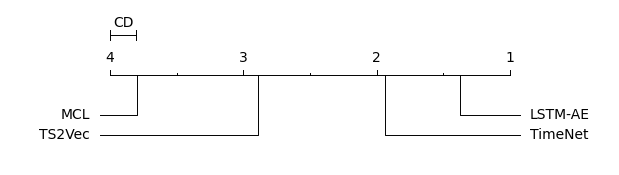

In [40]:
baselines_display_names = [MODEL_TO_DISPLAY_NAME_MAP[name] for name in df_summarized_baselines_internal_results_mul.columns]
do_cd_analysis_multiple(df_summarized_baselines_internal_results_mul,
                        df_summarized_baselines_internal_results_mul.columns,
                        baselines_display_names)

plt.savefig(PLOTS_OUTPUT_DIR / 'baselines_cd_internal.eps', format='eps', bbox_inches='tight', dpi=300)

### 3.5.2. External Clustering Metric

In [41]:
df_summarized_baselines_results_external_display \
    = summarize_baselines_results(baselines_tables=baselines_tables_display,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL)


In [42]:
df_summarized_baselines_results_external_display

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
BirdChicken,-0.01 ± 0.00,-0.03 ± 0.02,-0.01 ± 0.03,-0.01 ± 0.00
Meat,0.05 ± 0.02,-0.01 ± 0.02,0.43 ± 0.06,0.34 ± 0.11
FaceFour,0.21 ± 0.01,0.07 ± 0.05,0.34 ± 0.14,0.19 ± 0.06
Strawberry,-0.01 ± 0.01,-0.00 ± 0.00,-0.01 ± 0.02,0.01 ± 0.02
PigCVP,0.01 ± 0.01,0.12 ± 0.01,0.02 ± 0.01,0.05 ± 0.02
...,...,...,...,...
EOGVerticalSignal,0.04 ± 0.00,0.05 ± 0.00,0.08 ± 0.01,0.04 ± 0.00
DistalPhalanxOutlineCorrect,-0.00 ± 0.00,0.00 ± 0.00,-0.00 ± 0.00,0.00 ± 0.00
ECG200,0.19 ± 0.06,0.16 ± 0.09,0.22 ± 0.17,0.23 ± 0.06
PigArtPressure,0.01 ± 0.01,0.44 ± 0.02,0.14 ± 0.01,0.00 ± 0.01


In [43]:
df_summarized_baselines_external_results_mul \
    = summarize_baselines_results(baselines_tables=baselines_tables_mul,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL)

In [44]:
df_summarized_baselines_external_results_mul

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
BirdChicken,"[-0.0110864745011086, -0.0110864745011086, -0....","[-0.0398009950248756, -0.0398009950248756, -0....","[-0.0110864745011086, -0.0133333333333333, -0....","[-0.0110864745011086, -0.0110864745011086, -0...."
Meat,"[0.068360517252583, 0.0574763314230535, 0.0393...","[0.0261551202788852, -0.0217793622036506, -0.0...","[0.3298285617768769, 0.5083023700065076, 0.416...","[0.4131390238260467, 0.5013870072898523, 0.252..."
FaceFour,"[0.2003070531924501, 0.1986824031590575, 0.227...","[0.0068611050500642, 0.0527049104731287, 0.079...","[0.3770316540734212, 0.2033492111087967, 0.177...","[0.2185435851759229, 0.2104904529004709, 0.139..."
Strawberry,"[-0.0090023522703105, -0.0383817204544089, 0.0...","[-0.0037733427041697, -0.0028386165634782, 0.0...","[0.019853591023958, -0.0310876190657011, -0.01...","[0.0089095928104872, 0.0352375167411948, 0.001..."
PigCVP,"[0.0132695789950203, 0.005432014938041, 0.0034...","[0.1147387264512829, 0.1091305929428883, 0.126...","[0.0139853348225125, 0.0196803180391963, 0.038...","[0.0091416302031654, 0.0838593188166484, 0.053..."
...,...,...,...,...
EOGVerticalSignal,"[0.0353420939661834, 0.0353420939661834, 0.033...","[0.0439255262767568, 0.0526235770783559, 0.045...","[0.0761772754934297, 0.0858285334810657, 0.091...","[0.0427773345950841, 0.0353633190894678, 0.046..."
DistalPhalanxOutlineCorrect,"[-0.0017182965486296, -0.0019659912601773, -0....","[0.0017456666765303, 0.0007089831246657, 0.002...","[-0.0003513030251179, -0.0019698886830878, -0....","[-0.0005856688714065, 0.0042211621569673, -0.0..."
ECG200,"[0.1801678703884442, 0.1882073839766717, 0.298...","[0.1801678703884442, 0.1137146329934499, 0.004...","[0.3525831930596918, 0.390981911007438, 0.3461...","[0.1635385690375209, 0.2431092667646251, 0.166..."
PigArtPressure,"[0.0096745967542223, -0.0044134645696872, 0.01...","[0.4348072361666725, 0.4183453110064785, 0.436...","[0.1350386468406641, 0.1409632262520425, 0.142...","[-0.0021965103328795, 0.0270298082530099, -0.0..."


In [45]:
df_summarized_baselines_external_results_mul = summarize_baselines_results(baselines_tables=baselines_tables_mul,
                                                                           clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL)

Statistics=90.99444752915142, p=1.3395247648895524e-19
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 4
Critical difference: 0.19820512187990647

Algorithm Name                 Rank
-------------------------------------
TS2Vec                         2.19
TimeNet                        2.34
MCL                            2.61
LSTM-AE                        2.86


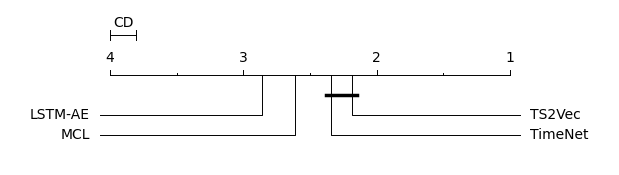

In [46]:
baselines_display_names = [MODEL_TO_DISPLAY_NAME_MAP[name] for name in df_summarized_baselines_external_results_mul.columns]
do_cd_analysis_multiple(df_summarized_baselines_external_results_mul,
                        df_summarized_baselines_external_results_mul.columns,
                        baselines_display_names)

plt.savefig(PLOTS_OUTPUT_DIR / 'baselines_cd.eps', format='eps', bbox_inches='tight', dpi=300)

# 4. TSRC

In [47]:
TSRC_MODEL_MAIN_DIR = CLUSTERING_MAIN_RESULTS_DIR / 'representations'

## 4.1. External Clustering Metric

### 4.1.1 Experiment 1

In [48]:
experiment_1_main_dir = TSRC_MODEL_MAIN_DIR / 'ts2vec_to_timenet_88c1e7d54bda54398837d6eff0022678'

In [49]:
experiment_1_results_dir = experiment_1_main_dir / 'compression_2'

In [50]:
experiment_1_encoders_list = ['tsrc-ts2vec-timenet - student-model-encoder']

In [51]:
experiment_1_encoder_metric_tables, experiment_1_metric_encoder_tables, experiment_1_encoder_metric_tables_display, experiment_1_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_1_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=experiment_1_encoders_list)

### ARI ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,0.19 ± 0.01
Adiac,0.22 ± 0.03
ArrowHead,0.03 ± 0.03
BME,0.31 ± 0.11
Beef,0.11 ± 0.05
...,...
Wine,0.00 ± 0.02
WordSynonyms,0.20 ± 0.02
Worms,0.05 ± 0.01
WormsTwoClass,0.00 ± 0.01


### CHS ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,87.38 ± 14.33
Adiac,187.46 ± 17.90
ArrowHead,67.48 ± 13.25
BME,190.43 ± 66.15
Beef,37.08 ± 16.03
...,...
Wine,48.29 ± 11.50
WordSynonyms,65.83 ± 5.51
Worms,57.47 ± 3.39
WormsTwoClass,47.24 ± 4.81


In [52]:
experiment_1_encoder_metric_tables_mul, experiment_1_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_1_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=experiment_1_encoders_list)

In [53]:
experiment_1_baselines_columns = ['ts2vec - ts2vec', 'timenet - timenet']
experiment_1_baseline_results_mul = df_summarized_baselines_external_results_mul[experiment_1_baselines_columns]

In [54]:
experiment_1_results_mul = pd.concat([experiment_1_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
                                      experiment_1_baseline_results_mul], axis=1)

In [55]:
experiment_1_results_mul

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
Fish,"[0.0929762279243248, 0.1392893903864162, 0.091...","[0.0696167914401941, 0.0521844293272864, 0.100...","[0.1037464356507365, 0.1141632311644858, 0.085..."
PowerCons,"[0.6027199258706454, 0.6027188236926064, 0.551...","[0.3303094258828358, 0.5029074445005466, 0.426...","[0.0085154058528909, 0.0107600568122157, 0.010..."
Haptics,"[0.0284120595918943, 0.0121129204153964, 0.029...","[0.0457634423236138, 0.0658865538860917, 0.089...","[0.0369663085536759, 0.034315396879518, 0.0538..."
ToeSegmentation1,"[0.0005247154925951, 0.0006431234361549, -0.00...","[0.1692130055723824, 0.1449957328603223, 0.157...","[-0.0066576804436808, -0.0073248138117806, 0.0..."
GunPointAgeSpan,"[-0.0033048146354169, -0.0033048146354169, -0....","[-0.0033048146354169, -0.0033048146354169, -0....","[-0.0033048146354169, -0.0033048146354169, -0...."
...,...,...,...
RefrigerationDevices,"[0.0102751958153268, 0.0101601148262433, 0.011...","[0.0488148229945894, 0.064286745863637, 0.0577...","[0.0092347240806816, 0.0087202954836809, 0.007..."
FreezerSmallTrain,"[0.2054185665510239, 0.2381634025911946, 0.240...","[0.2079516020695801, 0.2130569507106048, 0.214...","[0.0682444670618024, 0.0734246551809148, 0.321..."
SemgHandSubjectCh2,"[0.0683675272302541, 0.0466972614904718, 0.093...","[0.0750277674275449, 0.0653420124754291, 0.074...","[0.1160227094484118, 0.0638286614534631, 0.136..."
Adiac,"[0.2204710652966962, 0.1725006270901752, 0.198...","[0.2482650649878982, 0.2460619522194201, 0.264...","[0.1570163995759669, 0.1599347112061983, 0.125..."


In [56]:
experiment_1_results_mul

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
Fish,"[0.0929762279243248, 0.1392893903864162, 0.091...","[0.0696167914401941, 0.0521844293272864, 0.100...","[0.1037464356507365, 0.1141632311644858, 0.085..."
PowerCons,"[0.6027199258706454, 0.6027188236926064, 0.551...","[0.3303094258828358, 0.5029074445005466, 0.426...","[0.0085154058528909, 0.0107600568122157, 0.010..."
Haptics,"[0.0284120595918943, 0.0121129204153964, 0.029...","[0.0457634423236138, 0.0658865538860917, 0.089...","[0.0369663085536759, 0.034315396879518, 0.0538..."
ToeSegmentation1,"[0.0005247154925951, 0.0006431234361549, -0.00...","[0.1692130055723824, 0.1449957328603223, 0.157...","[-0.0066576804436808, -0.0073248138117806, 0.0..."
GunPointAgeSpan,"[-0.0033048146354169, -0.0033048146354169, -0....","[-0.0033048146354169, -0.0033048146354169, -0....","[-0.0033048146354169, -0.0033048146354169, -0...."
...,...,...,...
RefrigerationDevices,"[0.0102751958153268, 0.0101601148262433, 0.011...","[0.0488148229945894, 0.064286745863637, 0.0577...","[0.0092347240806816, 0.0087202954836809, 0.007..."
FreezerSmallTrain,"[0.2054185665510239, 0.2381634025911946, 0.240...","[0.2079516020695801, 0.2130569507106048, 0.214...","[0.0682444670618024, 0.0734246551809148, 0.321..."
SemgHandSubjectCh2,"[0.0683675272302541, 0.0466972614904718, 0.093...","[0.0750277674275449, 0.0653420124754291, 0.074...","[0.1160227094484118, 0.0638286614534631, 0.136..."
Adiac,"[0.2204710652966962, 0.1725006270901752, 0.198...","[0.2482650649878982, 0.2460619522194201, 0.264...","[0.1570163995759669, 0.1599347112061983, 0.125..."


In [57]:
experiment_1_baselines_results_display = df_summarized_baselines_results_external_display[
    experiment_1_baselines_columns]
experiment_1_results_display = pd.concat(
    [experiment_1_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
     experiment_1_baselines_results_display], axis=1)

In [58]:
experiment_1_results_display

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
Fish,0.11 ± 0.02,0.08 ± 0.02,0.09 ± 0.01
PowerCons,0.58 ± 0.04,0.41 ± 0.09,0.01 ± 0.00
Haptics,0.04 ± 0.02,0.07 ± 0.02,0.03 ± 0.01
ToeSegmentation1,-0.00 ± 0.00,0.16 ± 0.01,0.00 ± 0.01
GunPointAgeSpan,-0.00 ± 0.00,-0.00 ± 0.00,-0.00 ± 0.00
...,...,...,...
RefrigerationDevices,0.01 ± 0.00,0.06 ± 0.01,0.01 ± 0.00
FreezerSmallTrain,0.23 ± 0.01,0.21 ± 0.01,0.12 ± 0.10
SemgHandSubjectCh2,0.07 ± 0.02,0.07 ± 0.01,0.10 ± 0.02
Adiac,0.22 ± 0.03,0.25 ± 0.01,0.15 ± 0.01


### 4.1.2 Experiment 2

In [59]:
experiment_2_main_dir = TSRC_MODEL_MAIN_DIR / 'ts2vec_to_lstmae_aecc4ffa8c36aa6d9bccaf9d83dac024'

In [60]:
experiment_2_results_dir = experiment_2_main_dir / 'compression_2'

In [61]:
experiment_2_encoders_list = ['tsrc-ts2vec-lstmae - student-model-encoder']

In [62]:
experiment_2_encoder_metric_tables, experiment_2_metric_encoder_tables, experiment_2_encoder_metric_tables_display, experiment_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_2_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=experiment_2_encoders_list)

### ARI ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,0.24 ± 0.01
Adiac,0.18 ± 0.03
ArrowHead,0.09 ± 0.03
BME,0.21 ± 0.10
Beef,0.04 ± 0.00
...,...
Wine,0.00 ± 0.01
WordSynonyms,0.12 ± 0.02
Worms,0.06 ± 0.02
WormsTwoClass,-0.00 ± 0.00


### CHS ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,131.00 ± 10.24
Adiac,350.71 ± 103.66
ArrowHead,89.98 ± 10.55
BME,378.58 ± 91.95
Beef,962.64 ± 83.37
...,...
Wine,111.66 ± 34.72
WordSynonyms,101.93 ± 15.25
Worms,149.01 ± 118.86
WormsTwoClass,191.95 ± 86.71


In [63]:
experiment_2_encoder_metric_tables_mul, experiment_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_2_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=experiment_2_encoders_list)

In [64]:
experiment_2_baselines_columns = ['ts2vec - ts2vec', 'lstm-auto-encoder - encoder']
experiment_2_baselines_results_mul = df_summarized_baselines_external_results_mul[experiment_2_baselines_columns]

In [65]:
experiment_2_results_mul = pd.concat([experiment_2_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
                                      experiment_2_baselines_results_mul], axis=1)

In [66]:
experiment_2_baselines_results_display = df_summarized_baselines_results_external_display[
    experiment_2_baselines_columns]
experiment_2_results_display = pd.concat(
    [experiment_2_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
     experiment_2_baselines_results_display], axis=1)

In [67]:
experiment_2_results_display

,tsrc-ts2vec-lstmae - student-model-encoder,ts2vec - ts2vec,lstm-auto-encoder - encoder
Beef,0.04 ± 0.00,0.08 ± 0.03,0.04 ± 0.00
Trace,0.37 ± 0.22,0.43 ± 0.02,0.24 ± 0.06
Car,0.06 ± 0.03,0.06 ± 0.01,0.02 ± 0.00
Plane,0.53 ± 0.08,0.89 ± 0.05,0.53 ± 0.01
BeetleFly,0.12 ± 0.00,0.20 ± 0.04,0.12 ± 0.00
...,...,...,...
Meat,0.42 ± 0.20,-0.01 ± 0.02,0.05 ± 0.02
CBF,0.72 ± 0.09,0.63 ± 0.05,0.26 ± 0.13
UMD,0.11 ± 0.05,0.00 ± 0.00,0.01 ± 0.02
OSULeaf,0.07 ± 0.04,0.21 ± 0.04,0.06 ± 0.01


### 4.1.3 Experiment 3

In [68]:
experiment_3_main_dir = TSRC_MODEL_MAIN_DIR / 'mcl_to_lstmae_841548f56ad1cc5fd09a9f2e2086e6df'

In [69]:
experiment_3_results_dir = experiment_3_main_dir / 'compression_2'

In [70]:
experiment_3_encoders_list = ['tsrc-mcl-lstmae - student-model-encoder']

In [71]:
experiment_3_encoder_metric_tables, experiment_3_metric_encoder_tables, experiment_3_encoder_metric_tables_display, experiment_3_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_3_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=experiment_3_encoders_list)

### ARI ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,0.20 ± 0.04
Adiac,0.23 ± 0.04
ArrowHead,0.11 ± 0.03
BME,0.33 ± 0.13
Beef,0.11 ± 0.02
...,...
Wine,0.00 ± 0.01
WordSynonyms,0.09 ± 0.02
Worms,0.03 ± 0.02
WormsTwoClass,-0.01 ± 0.00


### CHS ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,417.49 ± 413.78
Adiac,110.43 ± 29.15
ArrowHead,56.73 ± 20.18
BME,90.85 ± 30.39
Beef,1517.10 ± 851.21
...,...
Wine,133.25 ± 192.82
WordSynonyms,162.90 ± 62.43
Worms,1252.17 ± 227.58
WormsTwoClass,404.59 ± 353.53


In [72]:
experiment_3_encoder_metric_tables_mul, experiment_3_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_3_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=experiment_3_encoders_list)

In [73]:
experiment_3_baselines_columns = ['mcl - mcl', 'lstm-auto-encoder - encoder']

In [74]:
experiment_3_baselines_results_mul = df_summarized_baselines_external_results_mul[experiment_3_baselines_columns]

In [75]:
experiment_3_results_mul = pd.concat([experiment_3_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
                                      experiment_3_baselines_results_mul], axis=1)

In [76]:
experiment_3_baselines_results_display = df_summarized_baselines_results_external_display[
    experiment_3_baselines_columns]
experiment_3_results_display = pd.concat(
    [experiment_3_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
     experiment_3_baselines_results_display], axis=1)

## 4.1.4. All Experiments

In [77]:
df_raw_data_external, df_raw_data_external_display = process_df_raw_data_results(datasets_to_skip=DATASETS_TO_SKIP,metric_to_keep=CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL)

In [78]:
df_raw_data_external_display

,raw
dataset_name,
ACSF1,0.09 ± 0.00
Adiac,0.14 ± 0.01
ArrowHead,0.09 ± 0.01
BME,0.35 ± 0.01
Beef,0.06 ± 0.01
...,...
Wine,-0.00 ± 0.01
WordSynonyms,0.16 ± 0.02
Worms,0.03 ± 0.00


In [79]:
all_experiments_results_mul = pd.concat([df_raw_data_external, experiment_1_results_mul, experiment_2_results_mul, experiment_3_results_mul,
                                         df_summarized_baselines_external_results_mul], axis=1)
all_experiments_results_mul = all_experiments_results_mul.loc[:, ~all_experiments_results_mul.columns.duplicated()]

In [80]:
all_experiments_results_mul

,raw,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet,tsrc-ts2vec-lstmae - student-model-encoder,lstm-auto-encoder - encoder,tsrc-mcl-lstmae - student-model-encoder,mcl - mcl
ACSF1,"[0.0817736530033513, 0.0926150938301606, 0.088...","[0.1890776126444916, 0.1976823449216087, 0.185...","[0.1595672751859364, 0.2051612903225806, 0.140...","[0.2025552684467413, 0.230024758046365, 0.2399...","[0.2342301261589907, 0.2436282436282436, 0.240...","[0.2153316106804479, 0.2219378687708822, 0.230...","[0.2000579458206577, 0.2483333333333333, 0.222...","[0.2581271227559437, 0.2871925360474979, 0.243..."
Adiac,"[0.1288944587674917, 0.1391998476786531, 0.145...","[0.2204710652966962, 0.1725006270901752, 0.198...","[0.2482650649878982, 0.2460619522194201, 0.264...","[0.1570163995759669, 0.1599347112061983, 0.125...","[0.1792846038231737, 0.2002070939695651, 0.167...","[0.0895573167664022, 0.1268761032347374, 0.091...","[0.2037873205646816, 0.2186901849556999, 0.286...","[0.3039894650361991, 0.2730681801564307, 0.330..."
ArrowHead,"[0.0962471497986977, 0.0693576582081398, 0.076...","[-0.0028817525223046, 0.0435211615187003, 0.03...","[-0.007615017411341, -0.0033966776638283, -0.0...","[0.0332085597924477, 0.0693459886663044, 0.018...","[0.0675626822399728, 0.0526656980708466, 0.145...","[0.0306864472980531, 0.0407091607573259, 0.052...","[0.1336854665259219, 0.0928349464305662, 0.123...","[0.0891879000835918, 0.0805409892223774, 0.152..."
BME,"[0.3550292251525254, 0.3550292251525254, 0.355...","[0.3914258857644883, 0.3550292251525254, 0.154...","[5.227778673276902e-05, -0.0005853140209722, -...","[0.6797352726540677, 0.2562850029273831, 0.407...","[0.3051933363900351, 0.3550292251525254, 0.153...","[0.2628428661926386, 0.1883976552436401, 0.153...","[0.5282104408619739, 0.3594227338270157, 0.370...","[0.2056986827800672, 0.2798407907973582, 0.293..."
Beef,"[0.0533127293799497, 0.0802445548337791, 0.053...","[0.1411383618695048, 0.074861760952786, 0.0554...","[0.0543478260869565, 0.0543478260869565, 0.100...","[0.0442031795269484, 0.0442031795269484, 0.156...","[0.0442031795269484, 0.0442031795269484, 0.044...","[0.0442031795269484, 0.0442031795269484, 0.044...","[0.1212121212121212, 0.1212121212121212, 0.115...","[0.1017161992465466, 0.2628297362110312, 0.215..."
...,...,...,...,...,...,...,...,...
Wine,"[0.0079068205470934, -0.0122102282781808, 0.00...","[0.0059756435793348, 0.0318616945277896, 0.004...","[0.0023130222647372, 0.0023130222647372, -0.01...","[-0.0068025604081536, -0.0179363047873425, 0.0...","[0.0079068205470934, -0.0035909372697179, 0.00...","[-0.0139928353991826, -0.0045991872300165, -0....","[0.0059756435793348, -0.0053912896975823, 0.00...","[-0.0166882518681444, 0.0946751895744901, 0.00..."
WordSynonyms,"[0.1988132139415665, 0.1487872560527381, 0.143...","[0.1966427698711924, 0.1756306975889335, 0.184...","[0.1927626100237714, 0.1844580208168144, 0.175...","[0.1428555647937571, 0.1652814356071807, 0.168...","[0.1229503771623263, 0.0941679047925491, 0.132...","[0.0615537851188984, 0.0589845494597888, 0.059...","[0.1089392155632717, 0.1175537593775946, 0.069...","[0.1311626914957118, 0.1569602832261662, 0.131..."
Worms,"[0.0248191661781275, 0.0343259608100887, 0.035...","[0.0307553165099137, 0.0543280718755222, 0.065...","[0.0520481298102271, 0.0495205615252068, 0.049...","[0.0622753496766431, 0.0637096273747577, 0.068...","[0.0331164413622774, 0.0779580172606538, 0.063...","[0.0437424068595912, 0.0436647876754495, 0.051...","[0.0319810902889548, 0.0548846246777902, 0.031...","[0.0103421078136576, -0.0101470944092107, -0.0..."
WormsTwoClass,"[0.0021575664510039, -0.0049270520227957, 0.00...","[-0.0013024430674507, 0.0059019268517838, -0.0...","[0.057472257979648, 0.0164716756737931, 0.0421...","[0.0023409835511396, -0.0007501822625919, 0.01...","[-0.0078891592378101, -0.0068124796115287, -0....","[-0.0028387099197115, -0.0028387099197115, -0....","[-0.0082476845427648, -0.0071211497583996, -0...."

In [81]:
full_baselines_display_names = ["Raw Data"] + baselines_display_names
all_experiment_results_display = pd.concat(
    [df_raw_data_external_display,experiment_1_results_display, experiment_2_results_display, experiment_3_results_display], axis=1)
all_experiment_results_display = all_experiment_results_display.loc[:,
                                 ~all_experiment_results_display.columns.duplicated()]
# # rename the columns to be more descriptive (use the mapping)
all_experiment_results_display.columns = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in
                                          all_experiment_results_display.columns]

# # order the columns and put the baselines first
all_experiment_results_display = all_experiment_results_display[full_baselines_display_names + all_experiment_results_display.columns.difference(full_baselines_display_names).tolist()]

In [82]:
all_experiment_results_display

,Raw Data,LSTM-AE,TS2Vec,MCL,TimeNet,LSTM-AE w/ TSRC (MCL),LSTM-AE w/ TSRC (TS2Vec),TimeNet w/ TSRC (TS2Vec)
ACSF1,0.09 ± 0.00,0.22 ± 0.01,0.18 ± 0.03,0.26 ± 0.01,0.22 ± 0.02,0.20 ± 0.04,0.24 ± 0.01,0.19 ± 0.01
Adiac,0.14 ± 0.01,0.12 ± 0.03,0.25 ± 0.01,0.30 ± 0.02,0.15 ± 0.01,0.23 ± 0.04,0.18 ± 0.03,0.22 ± 0.03
ArrowHead,0.09 ± 0.01,0.05 ± 0.01,-0.01 ± 0.00,0.09 ± 0.04,0.05 ± 0.02,0.11 ± 0.03,0.09 ± 0.03,0.03 ± 0.03
BME,0.35 ± 0.01,0.22 ± 0.07,-0.00 ± 0.00,0.25 ± 0.07,0.37 ± 0.18,0.33 ± 0.13,0.21 ± 0.10,0.31 ± 0.11
Beef,0.06 ± 0.01,0.04 ± 0.00,0.08 ± 0.03,0.18 ± 0.07,0.08 ± 0.04,0.11 ± 0.02,0.04 ± 0.00,0.11 ± 0.05
...,...,...,...,...,...,...,...,...
Wine,-0.00 ± 0.01,-0.01 ± 0.00,-0.01 ± 0.01,0.04 ± 0.05,0.01 ± 0.02,0.00 ± 0.01,0.00 ± 0.01,0.00 ± 0.02
WordSynonyms,0.16 ± 0.02,0.06 ± 0.01,0.20 ± 0.02,0.14 ± 0.01,0.16 ± 0.01,0.09 ± 0.02,0.12 ± 0.02,0.20 ± 0.02
Worms,0.03 ± 0.00,0.04 ± 0.00,0.05 ± 0.01,0.00 ± 0.01,0.06 ± 0.01,0.03 ± 0.02,0.06 ± 0.02,0.05 ± 0.01
WormsTwoClass,0.00 ± 0.00,-0.00 ± 0.00,0.05 ± 0.02,-0.00 ± 0.00,0.00 ± 0.01,-0.01 ± 0.00,-0.00 ± 0.00,0.00 ± 0.01


In [83]:
# save as latex
save_df_as_latex(all_experiment_results_display, 'all_experiments_results')

Statistics=177.79975223431674, p=5.678021071640372e-35
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 8
Critical difference: 0.44367525557972665

Algorithm Name                 Rank
-------------------------------------
TimeNet w/ TSRC (TS2Vec)       3.95
TS2Vec                         3.97
Raw Data                       4.15
TimeNet                        4.35
LSTM-AE w/ TSRC (TS2Vec)       4.44
MCL                            4.75
LSTM-AE w/ TSRC (MCL)          5.01
LSTM-AE                        5.38


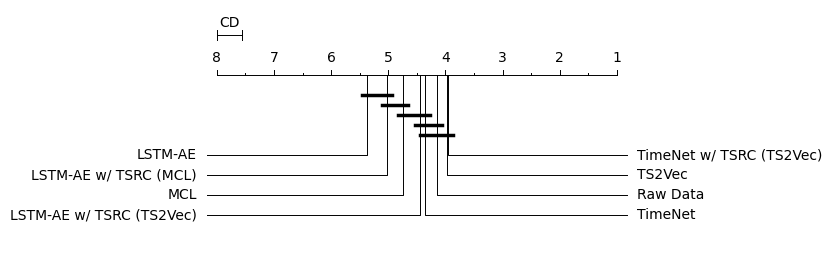

In [84]:
all_experiments_display_names = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in all_experiments_results_mul.columns]

do_cd_analysis_multiple(all_experiments_results_mul, all_experiments_results_mul.columns, all_experiments_display_names)

# save the figure as eps
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd.eps', format='eps', bbox_inches='tight', dpi=300)

# save the figure as png
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd.png', format='png', bbox_inches='tight', dpi=300)

In [85]:
# Calculating improvements:

ranks_original = {
    "TimeNet_w_TSRC_TS2Vec": 3.95,
    "TS2Vec": 3.97,
    "Raw Data": 4.15,
    "TimeNet": 4.35,
    "LSTM_AE_w_TSRC_TS2Vec": 4.44,
    "MCL": 4.75,
    "LSTM_AE_w_TSRC_MCL": 5.01,
    "LSTM_AE": 5.38
}
improvements = {
    "TimeNet_w_TSRC_TS2Vec": ((ranks_original["TimeNet"] - ranks_original["TimeNet_w_TSRC_TS2Vec"]) / ranks_original[
        "TimeNet"]) * 100,
    "LSTM_AE_w_TSRC_TS2Vec": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_TS2Vec"]) / ranks_original[
        "LSTM_AE"]) * 100,
    "LSTM_AE_w_TSRC_MCL": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_MCL"]) / ranks_original[
        "LSTM_AE"]) * 100,
}

improvements = {k: round(v, 2) for k, v in improvements.items()}

# Calculate the mean of the improvements:
mean_improvement = sum(improvements.values()) / len(improvements)

mean_improvement = round(mean_improvement, 2)

print(f'Details of the improvements: {improvements}')
print(f'Mean improvement: {mean_improvement}')

Details of the improvements: {'TimeNet_w_TSRC_TS2Vec': 9.2, 'LSTM_AE_w_TSRC_TS2Vec': 17.47, 'LSTM_AE_w_TSRC_MCL': 6.88}
Mean improvement: 11.18


## 4.2. Internal Clustering Metric

### 4.2.1 Experiment 1

In [86]:
experiment_1_results_mul_internal = pd.concat(
    [experiment_1_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_1_baseline_results_mul], axis=1)

In [87]:
experiment_1_baselines_results_display_internal = df_summarized_baselines_results_internal_display[
    experiment_1_baselines_columns]
experiment_1_results_display_internal = pd.concat(
    [experiment_1_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_1_baselines_results_display_internal], axis=1)

In [88]:
experiment_1_results_display_internal

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
Fish,66.34 ± 10.68,52.29 ± 3.40,66.84 ± 7.44
PowerCons,194.12 ± 15.23,113.41 ± 4.12,222.43 ± 28.75
Haptics,64.85 ± 22.88,34.53 ± 6.45,127.08 ± 30.98
ToeSegmentation1,65.86 ± 11.77,51.80 ± 8.37,210.85 ± 14.27
GunPointAgeSpan,719.45 ± 93.70,679.39 ± 76.15,614.35 ± 177.81
...,...,...,...
RefrigerationDevices,309.15 ± 42.41,85.71 ± 7.46,348.20 ± 59.14
FreezerSmallTrain,1537.79 ± 212.49,1150.65 ± 187.99,2739.45 ± 753.94
SemgHandSubjectCh2,335.38 ± 103.66,481.21 ± 35.12,332.97 ± 48.74
Adiac,187.46 ± 17.90,106.86 ± 19.94,410.73 ± 136.96


### 4.2.2 Experiment 2

In [89]:
experiment_2_results_mul_internal = pd.concat(
    [experiment_2_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_2_baselines_results_mul], axis=1)

In [90]:
experiment_2_baselines_results_display_internal = df_summarized_baselines_results_internal_display[
    experiment_2_baselines_columns]
experiment_2_results_display_internal = pd.concat(
    [experiment_2_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_2_baselines_results_display_internal], axis=1)

In [91]:
experiment_2_results_display_internal

,tsrc-ts2vec-lstmae - student-model-encoder,ts2vec - ts2vec,lstm-auto-encoder - encoder
Beef,962.64 ± 83.37,44.79 ± 6.51,1212.85 ± 418.01
Trace,359.08 ± 69.95,70.32 ± 8.19,915.26 ± 1118.23
Car,72.72 ± 12.38,36.39 ± 3.58,182.98 ± 49.58
Plane,286.56 ± 56.02,47.89 ± 5.64,278.77 ± 45.91
BeetleFly,54.46 ± 1.85,7.39 ± 0.91,59.23 ± 0.42
...,...,...,...
Meat,54.84 ± 15.11,64.30 ± 11.59,124.33 ± 34.75
CBF,319.67 ± 51.40,176.18 ± 9.18,329.46 ± 43.82
UMD,314.24 ± 149.05,208.07 ± 16.08,58.87 ± 5.35
OSULeaf,1109.81 ± 986.35,28.41 ± 1.88,536.56 ± 240.02


### 4.2.3 Experiment 3

In [92]:
experiment_3_results_mul_internal = pd.concat(
    [experiment_3_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_3_baselines_results_mul], axis=1)

In [93]:
experiment_3_baselines_results_display_internal = df_summarized_baselines_results_internal_display[
    experiment_3_baselines_columns]
experiment_3_results_display_internal = pd.concat(
    [experiment_3_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_3_baselines_results_display_internal], axis=1)

## 4.2.4. All Experiments

In [94]:
df_raw_data_internal, df_raw_data_internal_display = process_df_raw_data_results(datasets_to_skip=DATASETS_TO_SKIP,metric_to_keep=CLUSTERING_METRIC_TO_CONSIDER_INTERNAL)

In [95]:
all_experiments_results_mul_internal = pd.concat(
    [df_raw_data_internal, experiment_1_results_mul_internal, experiment_2_results_mul_internal, experiment_3_results_mul_internal,
     df_summarized_baselines_internal_results_mul], axis=1)
all_experiments_results_mul_internal = all_experiments_results_mul_internal.loc[:,
                                       ~all_experiments_results_mul_internal.columns.duplicated()]

In [96]:
full_baselines_display_names = ["Raw Data"] + baselines_display_names
all_experiment_results_display_internal = pd.concat(
    [df_raw_data_internal_display, experiment_1_results_display_internal, experiment_2_results_display_internal,
     experiment_3_results_display_internal], axis=1)
all_experiment_results_display_internal = all_experiment_results_display_internal.loc[:,
                                          ~all_experiment_results_display_internal.columns.duplicated()]
# rename the columns to be more descriptive (use the mapping)
all_experiment_results_display_internal.columns = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in
                                                   all_experiment_results_display_internal.columns]
# order the columns and put the baselines first
all_experiment_results_display_internal = all_experiment_results_display_internal[full_baselines_display_names  + all_experiment_results_display_internal.columns.difference(full_baselines_display_names ).tolist()]

In [97]:
all_experiment_results_display_internal

,Raw Data,LSTM-AE,TS2Vec,MCL,TimeNet,LSTM-AE w/ TSRC (MCL),LSTM-AE w/ TSRC (TS2Vec),TimeNet w/ TSRC (TS2Vec)
ACSF1,10.42 ± 0.88,124.22 ± 27.73,164.76 ± 33.72,67.70 ± 13.01,106.62 ± 23.38,417.49 ± 413.78,131.00 ± 10.24,87.38 ± 14.33
Adiac,131.97 ± 9.10,549.68 ± 322.67,106.86 ± 19.94,93.71 ± 9.83,410.73 ± 136.96,110.43 ± 29.15,350.71 ± 103.66,187.46 ± 17.90
ArrowHead,25.07 ± 1.53,119.86 ± 32.01,63.58 ± 9.14,33.99 ± 6.30,70.94 ± 24.64,56.73 ± 20.18,89.98 ± 10.55,67.48 ± 13.25
BME,40.96 ± 0.33,182.64 ± 78.64,462.14 ± 80.76,24.75 ± 3.34,64.21 ± 8.69,90.85 ± 30.39,378.58 ± 91.95,190.43 ± 66.15
Beef,29.63 ± 0.12,1212.85 ± 418.01,44.79 ± 6.51,25.39 ± 7.57,180.20 ± 140.03,1517.10 ± 851.21,962.64 ± 83.37,37.08 ± 16.03
...,...,...,...,...,...,...,...,...
Wine,18.69 ± 2.93,55.94 ± 13.78,41.02 ± 2.10,18.71 ± 3.79,33.06 ± 5.19,133.25 ± 192.82,111.66 ± 34.72,48.29 ± 11.50
WordSynonyms,20.10 ± 0.93,269.52 ± 59.45,25.22 ± 2.80,40.03 ± 3.83,95.94 ± 20.68,162.90 ± 62.43,101.93 ± 15.25,65.83 ± 5.51
Worms,10.07 ± 0.12,394.48 ± 6.15,22.74 ± 3.37,18.98 ± 1.48,103.10 ± 68.16,1252.17 ± 227.58,149.01 ± 118.86,57.47 ± 3.39
WormsTwoClass,17.40 ± 0.14,268.58 ± 1.22,32.79 ± 4.33,23.65 ± 1.19,50.21 ± 6.22,404.59 ± 353.53,191.95 ± 86.71,47.24 ± 4.81


In [98]:
all_experiments_results_mul_internal

,raw,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet,tsrc-ts2vec-lstmae - student-model-encoder,lstm-auto-encoder - encoder,tsrc-mcl-lstmae - student-model-encoder,mcl - mcl
ACSF1,"[9.76519857640636, 11.308566870534031, 11.2358...","[104.87588187115932, 71.50360777852687, 69.427...","[0.1595672751859364, 0.2051612903225806, 0.140...","[0.2025552684467413, 0.230024758046365, 0.2399...","[150.79230325574713, 125.72343246228888, 121.4...","[0.2153316106804479, 0.2219378687708822, 0.230...","[188.73885343459804, 208.039751431733, 268.714...","[0.2581271227559437, 0.2871925360474979, 0.243..."
Adiac,"[129.67483935746856, 131.54619658158515, 145.3...","[172.4877504672844, 177.3673014059008, 220.257...","[0.2482650649878982, 0.2460619522194201, 0.264...","[0.1570163995759669, 0.1599347112061983, 0.125...","[422.1564342189754, 207.34784984001584, 400.39...","[0.0895573167664022, 0.1268761032347374, 0.091...","[161.85317455906593, 107.52059884925426, 81.14...","[0.3039894650361991, 0.2730681801564307, 0.330..."
ArrowHead,"[23.429309966204844, 27.52001751298646, 26.118...","[89.35278698937526, 53.44127669049513, 53.9140...","[-0.007615017411341, -0.0033966776638283, -0.0...","[0.0332085597924477, 0.0693459886663044, 0.018...","[99.83825590417406, 85.36280220773578, 91.6596...","[0.0306864472980531, 0.0407091607573259, 0.052...","[39.23225381211913, 50.47258274863145, 69.5980...","[0.0891879000835918, 0.0805409892223774, 0.152..."
BME,"[41.2027763984049, 41.2027763984049, 41.202776...","[59.473760986531616, 219.5620834094371, 239.32...","[5.227778673276902e-05, -0.0005853140209722, -...","[0.6797352726540677, 0.2562850029273831, 0.407...","[393.8454433463522, 431.9616625317376, 417.384...","[0.2628428661926386, 0.1883976552436401, 0.153...","[69.99460619696292, 105.66862296404364, 135.40...","[0.2056986827800672, 0.2798407907973582, 0.293..."
Beef,"[29.569082440648693, 29.863942429589756, 29.56...","[25.818711393422877, 41.0938318295428, 32.5537...","[0.0543478260869565, 0.0543478260869565, 0.100...","[0.0442031795269484, 0.0442031795269484, 0.156...","[980.9337206904996, 821.7666444548152, 1068.69...","[0.0442031795269484, 0.0442031795269484, 0.044...","[717.138055363535, 2950.444809893261, 1363.704...","[0.1017161992465466, 0.2628297362110312, 0.215..."
...,...,...,...,...,...,...,...,...
Wine,"[16.304862296819678, 22.276765875158837, 16.30...","[53.75197516425708, 26.387179745222, 59.512036...","[0.0023130222647372, 0.0023130222647372, -0.01...","[-0.0068025604081536, -0.0179363047873425, 0.0...","[94.16178261597106, 69.77042083692186, 153.994...","[-0.0139928353991826, -0.0045991872300165, -0....","[39.181552577249235, 31.646990284735484, 518.7...","[-0.0166882518681444, 0.0946751895744901, 0.00..."
WordSynonyms,"[21.18636234715963, 20.051328366485183, 21.020...","[55.61145642416779, 66.55969832607754, 67.4779...","[0.1927626100237714, 0.1844580208168144, 0.175...","[0.1428555647937571, 0.1652814356071807, 0.168...","[103.0649084015582, 113.57793154189758, 90.672...","[0.0615537851188984, 0.0589845494597888, 0.059...","[117.6033987811796, 197.34883413555912, 269.50...","[0.1311626914957118, 0.1569602832261662, 0.131..."
Worms,"[9.957826889086624, 9.91409412562196, 10.23156...","[55.986246899577615, 61.30432021046857, 52.145...","[0.0520481298102271, 0.0495205615252068, 0.049...","[0.0622753496766431, 0.0637096273747577, 0.068...","[100.42308302919744, 98.15058144030648, 94.080...","[0.0437424068595912, 0.0436647876754495, 0.051...","[952.2549476071258, 1386.8344147454943, 1585.4...","[0.0103421078136576, -0.0101470944092107, -0.0..."
WormsTwoClass,"[17.414798800320458, 17.64744111875028, 17.414...","[42.484023960871795, 55.81929716493718, 47.673...","[0.057472257979648, 0.0164716756737931, 0.0421...","[0.0023409835511396, -0.0007501822625919, 0.01...","[199.76178161111773, 116.1361974389188, 305.49...","[-0.0028387099197115, -0.0028387099197115, -0....","[217.71115642299276, 1079.4172318269304, 414.3..."

In [99]:
# save as latex
save_df_as_latex(all_experiment_results_display_internal, 'all_experiments_results_internal')

Statistics=3206.791260166944, p=0.0
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 8
Critical difference: 0.44367525557972665

Algorithm Name                 Rank
-------------------------------------
LSTM-AE w/ TSRC (TS2Vec)       1.71
LSTM-AE w/ TSRC (MCL)          2.27
TimeNet w/ TSRC (TS2Vec)       2.40
Raw Data                       3.62
TS2Vec                         6.19
TimeNet                        6.34
MCL                            6.61
LSTM-AE                        6.86


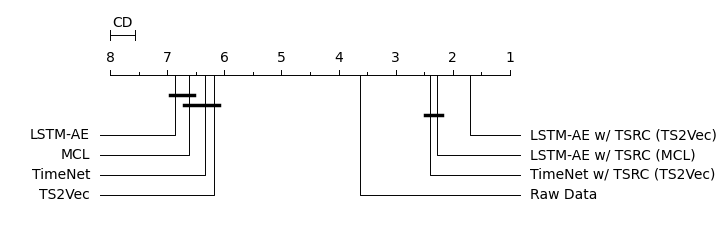

In [100]:
all_experiments_display_names = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in all_experiments_results_mul_internal.columns]

do_cd_analysis_multiple(all_experiments_results_mul_internal, all_experiments_results_mul_internal.columns,
                        all_experiments_display_names)

# save the figure as eps
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd_internal.eps', format='eps', bbox_inches='tight', dpi=300)

# save the figure as png
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd_internal.png', format='png', bbox_inches='tight', dpi=300)

In [101]:
# Calculating improvements:

ranks_original = {
    "LSTM_AE_w_TSRC_TS2Vec": 1.71,
    "LSTM_AE_w_TSRC_MCL": 2.27,
    "TimeNet_w_TSRC_TS2Vec": 2.40,
    "Raw Data": 3.62,
    "TS2Vec": 6.19,
    "TimeNet": 6.34,
    "MCL": 5.61,
    "LSTM_AE": 6.86
}
improvements = {
    "TimeNet_w_TSRC_TS2Vec": ((ranks_original["TimeNet"] - ranks_original["TimeNet_w_TSRC_TS2Vec"]) / ranks_original[
        "TimeNet"]) * 100,
    "LSTM_AE_w_TSRC_TS2Vec": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_TS2Vec"]) / ranks_original[
        "LSTM_AE"]) * 100,
    "LSTM_AE_w_TSRC_MCL": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_MCL"]) / ranks_original[
        "LSTM_AE"]) * 100,
}

improvements = {k: round(v, 2) for k, v in improvements.items()}

# Calculate the mean of the improvements:
mean_improvement = sum(improvements.values()) / len(improvements)

mean_improvement = round(mean_improvement, 2)

print(f'Details of the improvements: {improvements}')
print(f'Mean improvement: {mean_improvement}')

Details of the improvements: {'TimeNet_w_TSRC_TS2Vec': 62.15, 'LSTM_AE_w_TSRC_TS2Vec': 75.07, 'LSTM_AE_w_TSRC_MCL': 66.91}
Mean improvement: 68.04
